# Introduction to scvi-tools

In this introductory tutorial, we go through the different steps of an scvi-tools workflow.

While we focus on scVI in this tutorial, the API is consistent across all models.

In [4]:
import scanpy as sc
import scvi
import anndata as ad
import pandas as pd

sc.set_figure_params(figsize=(4, 4))

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

## Loading and preparing data

#### Cross-tissue immune cell analysis reveals tissue-specific features in humans - Global

Despite their crucial role in health and disease, our knowledge of immune cells within human tissues remains limited. We surveyed the immune compartment of 16 tissues from 12 adult donors by single-cell RNA sequencing and VDJ sequencing generating a dataset of ~360,000 cells. To systematically resolve immune cell heterogeneity across tissues, we developed CellTypist, a machine learning tool for rapid and precise cell type annotation. Using this approach, combined with detailed curation, we determined the tissue distribution of finely phenotyped immune cell types, revealing hitherto unappreciated tissue-specific features and clonal architecture of T and B cells. Our multitissue approach lays the foundation for identifying highly resolved immune cell types by leveraging a common reference dataset, tissue-integrated expression analysis, and antigen receptor sequencing.

```{important}
All scvi-tools models require AnnData objects as input.
```

In [5]:
#adata = ad.read_h5ad("/home/owkin/data/cross-tissue/omics/raw/local.h5ad")
adata = scvi.data.heart_cell_atlas_subsampled()

adata

INFO     File data/hca_subsampled_20k.h5ad already downloaded                                                      


AnnData object with n_obs × n_vars = 18641 × 26662
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts'
    uns: 'cell_type_colors'

In [6]:
adata.obs["cell_type"].value_counts()

cell_type
Ventricular_Cardiomyocyte    5307
Endothelial                  4109
Pericytes                    3204
Fibroblast                   2446
Atrial_Cardiomyocyte         1009
Myeloid                       957
Lymphoid                      653
Smooth_muscle_cells           641
Neuronal                      153
Adipocytes                    145
Mesothelial                    17
Name: count, dtype: int64

Now we preprocess the data to remove, for example, genes that are very lowly expressed and other outliers. For these tasks we prefer the [Scanpy preprocessing module](https://scanpy.readthedocs.io/en/stable/api/index.html#module-scanpy.pp).

In [7]:
sc.pp.filter_genes(adata, min_counts=3)

In scRNA-seq analysis, it's popular to normalize the data. These values are not used by scvi-tools, but given their popularity in other tasks as well as for visualization, we store them in the anndata object separately (via the `.raw` attribute).

```{important}
Unless otherwise specified, scvi-tools models require the raw counts (not log library size normalized). scvi-tools models will run for non-negative real-valued data, but we strongly suggest checking that these possibly non-count values are intended to represent pseudocounts (e.g. SoupX-corrected counts), and not some other normalized data, in which the variance/covariance structure of the data has changed dramatically.
```

In [8]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

Finally, we perform feature selection, to reduce the number of features (genes in this case) used as input to the scvi-tools model. For best practices of how/when to perform feature selection, please refer to the model-specific tutorial. For scVI, we recommend anywhere from 1,000 to 10,000 HVGs, but it will be context-dependent.

In [9]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="cell_source",
)

Now it's time to run `setup_anndata()`, which alerts scvi-tools to the locations of various matrices inside the anndata. It's important to run this function with the correct arguments so scvi-tools is notified that your dataset has batches, annotations, etc. For example, if batches are registered with scvi-tools, the subsequent model will correct for batch effects. See the full documentation for details.

In this dataset, there is a "cell_source" categorical covariate, and within each "cell_source", multiple "donors", "gender" and "age_group". There are also two continuous covariates we'd like to correct for: "percent_mito" and "percent_ribo". These covariates can be registered using the `categorical_covariate_keys` argument. If you only have one categorical covariate, you can also use the `batch_key` argument instead.

In [10]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["cell_source", "donor"],
    continuous_covariate_keys=["percent_mito", "percent_ribo"],
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


```{warning}
If the adata is modified after running `setup_anndata`, please run `setup_anndata` again, before creating an instance of a model.
```

## Creating and training a model

While we highlight the scVI model here, the API is consistent across all scvi-tools models and is inspired by that of [scikit-learn](https://scikit-learn.org/stable/). For a full list of options, see the scvi [documentation](https://scvi-tools.org).

In [11]:
model = scvi.model.SCVI(adata)

We can see an overview of the model by printing it.

In [12]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained
Model's adata is minified?: False

```{important}
All scvi-tools models run faster when using a GPU. By default, scvi-tools will use a GPU if one is found to be available. Please see the installation page for more information about installing scvi-tools when a GPU is available.
```

In [13]:
model.train()

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [10:16<00:00,  1.49s/it, v_num=1, train_loss_step=231, train_loss_epoch=285]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [10:16<00:00,  1.54s/it, v_num=1, train_loss_step=231, train_loss_epoch=285]


### Saving and loading

Saving consists of saving the model neural network weights, as well as parameters used to initialize the model.

In [11]:
# model.save("my_model/")

In [12]:
# model = scvi.model.SCVI.load("my_model/", adata=adata, use_gpu=True)

## Create signature matrix

In [14]:
latent = model.get_latent_representation()

latent.shape

(18641, 10)

It's often useful to store the outputs of scvi-tools back into the original anndata, as it permits interoperability with Scanpy.

In [15]:
adata.obsm["X_scVI"] = latent

The `model.get...()` functions default to using the anndata that was used to initialize the model. It's possible to also query a subset of the anndata, or even use a completely independent anndata object as long as the anndata is organized in an equivalent fashion.

We will use it to compute the **mean gene expression vector for each cell type present in the dataset** .

In [36]:
# Denoised signature computation

df_signature_denoised = pd.DataFrame()

for cell_type in adata.obs["cell_type"].unique():
    adata_subset = adata[adata.obs.cell_type == cell_type]
    latent_subset = model.get_latent_representation(adata_subset)
    denoised = model.get_normalized_expression(adata_subset, library_size=1e4)
    df = denoised.mean(axis=0).to_frame()
    df.columns = [cell_type]
    df_signature_denoised = pd.concat([df_signature_denoised, df], axis=1)

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                         

/home/owkin/deepdeconv/scvi/data/fields/_arraylike_field.py:418: UserWarning: Category 1 in adata.obs['donor'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(


In [37]:
df_signature_denoised

,Myeloid,Ventricular_Cardiomyocyte,Fibroblast,Endothelial,Adipocytes,Pericytes,Atrial_Cardiomyocyte,Smooth_muscle_cells,Neuronal,Lymphoid,Mesothelial
ISG15,18.351303,0.791804,2.206896,24.705400,0.549879,7.166814,1.240370,7.760505,3.799050,22.932484,10.140882
TNFRSF18,0.550572,0.062204,0.171512,0.378440,0.534023,0.117600,0.067614,0.120658,0.192306,5.076809,0.138767
VWA1,0.305320,0.148477,1.604000,4.192390,1.080163,0.851818,0.264636,0.751174,13.418933,0.760571,4.914508
HES5,0.066485,0.074869,0.059959,1.390819,0.017128,0.442908,0.065210,0.386558,0.119861,0.086878,0.036676
SPSB1,2.637672,1.316297,8.984466,1.542599,7.624077,3.514774,1.394853,1.408836,4.271957,0.956693,4.669891
...,...,...,...,...,...,...,...,...,...,...,...
RCAN1,6.259481,7.348011,3.263060,5.210776,4.346478,3.455129,7.064335,3.958271,9.977087,4.337422,5.402370
RUNX1,34.737938,3.573847,15.454363,2.003988,14.689039,18.057608,7.712873,6.536679,8.442416,23.220238,18.623093
ITGB2,11.733432,0.205258,0.577777,1.114667,0.578870,1.137495,0.691341,0.418175,1.568672,22.123396,0.547804
S100B,1.836907,0.079573,0.562675,0.490909,2.027772,0.474762,0.044826,1.170311,27.784990,5.014529,0.719443


In [56]:
library_size = adata.layers["counts"].sum(axis=1)

library_size, library_size.shape, library_size.max()

adata.layers["normalized"] = adata.layers["counts"] / library_size

In [38]:
df_signature = pd.DataFrame()

for cell_type in adata.obs["cell_type"].unique():
    adata_subset = adata[adata.obs.cell_type == cell_type]
    df = pd.DataFrame(adata_subset.layers["counts"].mean(axis=0).T,
             index=adata.var_names,
             columns=[cell_type])
    df_signature = pd.concat([df_signature, df], axis=1) 

In [39]:
df_signature_denoised

,Myeloid,Ventricular_Cardiomyocyte,Fibroblast,Endothelial,Adipocytes,Pericytes,Atrial_Cardiomyocyte,Smooth_muscle_cells,Neuronal,Lymphoid,Mesothelial
ISG15,18.351303,0.791804,2.206896,24.705400,0.549879,7.166814,1.240370,7.760505,3.799050,22.932484,10.140882
TNFRSF18,0.550572,0.062204,0.171512,0.378440,0.534023,0.117600,0.067614,0.120658,0.192306,5.076809,0.138767
VWA1,0.305320,0.148477,1.604000,4.192390,1.080163,0.851818,0.264636,0.751174,13.418933,0.760571,4.914508
HES5,0.066485,0.074869,0.059959,1.390819,0.017128,0.442908,0.065210,0.386558,0.119861,0.086878,0.036676
SPSB1,2.637672,1.316297,8.984466,1.542599,7.624077,3.514774,1.394853,1.408836,4.271957,0.956693,4.669891
...,...,...,...,...,...,...,...,...,...,...,...
RCAN1,6.259481,7.348011,3.263060,5.210776,4.346478,3.455129,7.064335,3.958271,9.977087,4.337422,5.402370
RUNX1,34.737938,3.573847,15.454363,2.003988,14.689039,18.057608,7.712873,6.536679,8.442416,23.220238,18.623093
ITGB2,11.733432,0.205258,0.577777,1.114667,0.578870,1.137495,0.691341,0.418175,1.568672,22.123396,0.547804
S100B,1.836907,0.079573,0.562675,0.490909,2.027772,0.474762,0.044826,1.170311,27.784990,5.014529,0.719443


In [40]:
df_signature

,Myeloid,Ventricular_Cardiomyocyte,Fibroblast,Endothelial,Adipocytes,Pericytes,Atrial_Cardiomyocyte,Smooth_muscle_cells,Neuronal,Lymphoid,Mesothelial
ISG15,1.786834,0.027134,0.062960,1.158677,0.020690,0.387953,0.031715,0.536662,0.215686,1.033692,0.176471
TNFRSF18,0.011494,0.000188,0.000409,0.003164,0.013793,0.000000,0.000000,0.000000,0.000000,0.128637,0.000000
VWA1,0.003135,0.001884,0.035568,0.153565,0.041379,0.017166,0.000991,0.023401,0.594771,0.004594,0.000000
HES5,0.000000,0.000754,0.000000,0.034315,0.000000,0.009363,0.000991,0.000000,0.000000,0.000000,0.000000
SPSB1,0.012539,0.026380,0.321341,0.039426,0.634483,0.034332,0.050545,0.028081,0.104575,0.010720,0.058824
...,...,...,...,...,...,...,...,...,...,...,...
RCAN1,0.159874,0.276238,0.044971,0.183986,0.131034,0.070537,0.129832,0.062402,0.091503,0.024502,0.058824
RUNX1,0.955066,0.126060,0.367538,0.024337,0.875862,0.168851,0.232904,0.057722,0.169935,0.346095,0.176471
ITGB2,0.836989,0.005276,0.002862,0.005354,0.006897,0.005618,0.007929,0.001560,0.000000,0.728944,0.000000
S100B,0.021944,0.001131,0.001226,0.000730,0.082759,0.003121,0.000991,0.000000,0.732026,0.053599,0.000000


In [41]:
import seaborn as sns 

Text(0.5, 1.0, 'Correlation 0.9772025454542342')

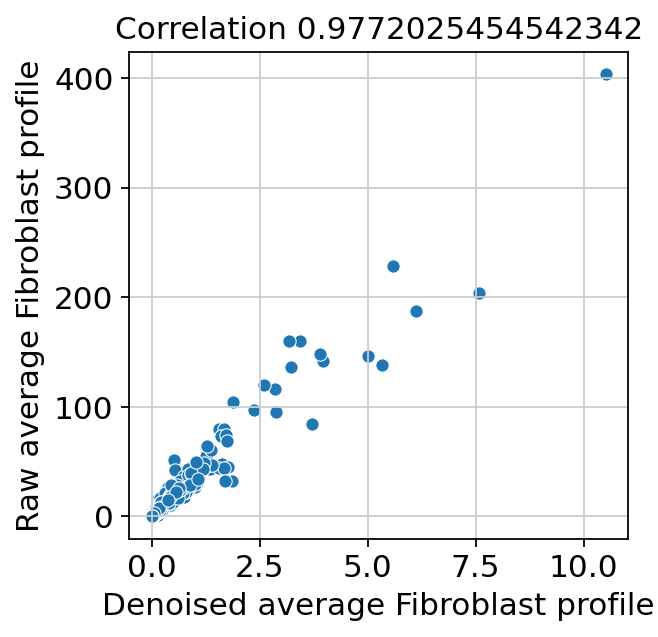

In [49]:
from scipy.stats import spearmanr
cell_type = "Fibroblast"

x_raw = df_signature[cell_type].values
x_denoised = df_signature_denoised[cell_type].values
corr = spearmanr(x_raw, x_denoised)[0]

ax = sns.scatterplot(x=x_raw,
                y=x_denoised,
                )

ax.set_xlabel(f"Denoised average {cell_type} profile")
ax.set_ylabel(f"Raw average {cell_type} profile")
ax.set_title(f"Correlation {corr}")

Let's store the normalized values back in the anndata.

In [17]:
adata.layers["scvi_normalized"] = model.get_normalized_expression(library_size=10e4)

## Interoperability with Scanpy

Scanpy is a powerful python library for visualization and downstream analysis of scRNA-seq data. We show here how to feed the objects produced by scvi-tools into a scanpy workflow.

### Visualization without batch correction

```{warning}
We use UMAP to *qualitatively* assess our low-dimension embeddings of cells. We do not advise using UMAP or any similar approach quantitatively. We do recommend using the embeddings produced by scVI as a plug-in replacement of what you would get from PCA, as we show below.
```

First, we demonstrate the presence of nuisance variation with respect to nuclei/whole cell, age group, and donor by plotting the UMAP results of the top 30 PCA components for the raw count data.

In [18]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)

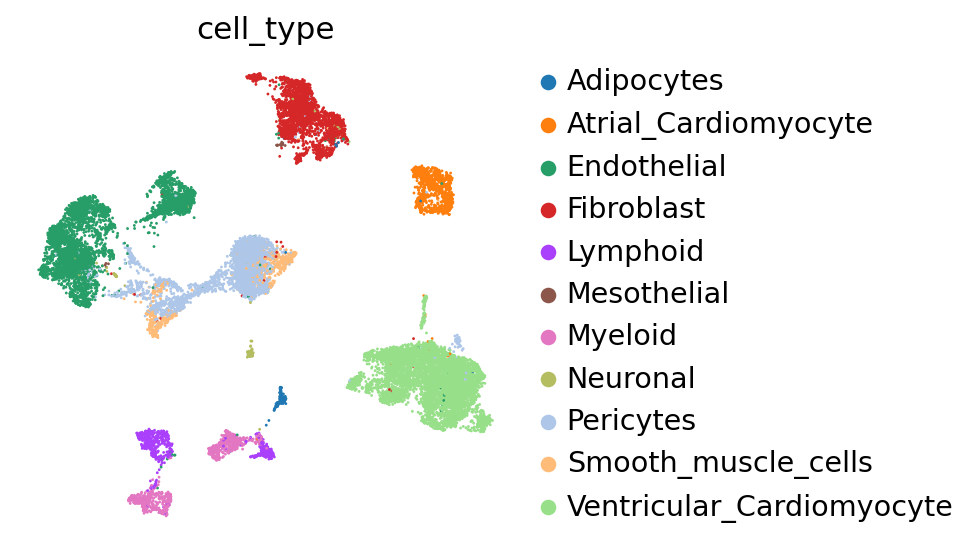

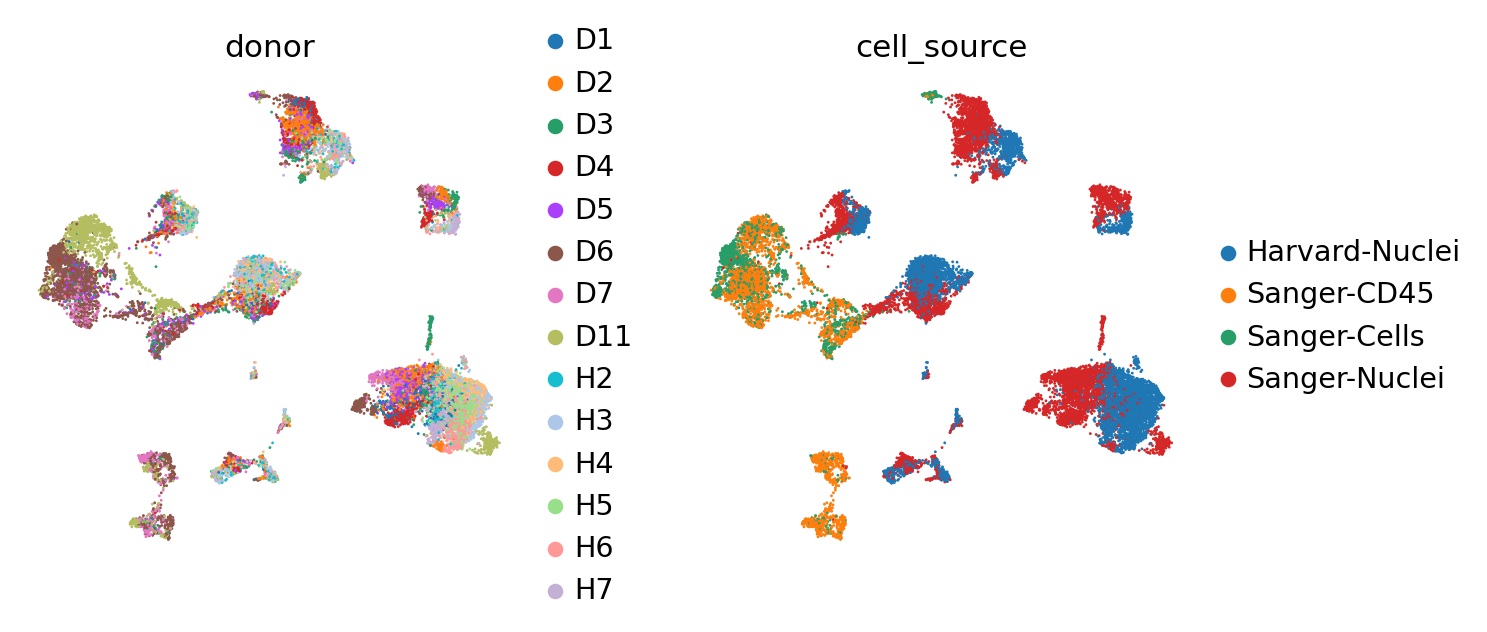

In [19]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor", "cell_source"],
    ncols=2,
    frameon=False,
)

We see that while the cell types are generally well separated, nuisance variation plays a large part in the variation of the data.

### Visualization with batch correction (scVI)

Now, let us try using the scVI latent space to generate the same UMAP plots to see if scVI successfully accounts for batch effects in the data.

In [20]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)

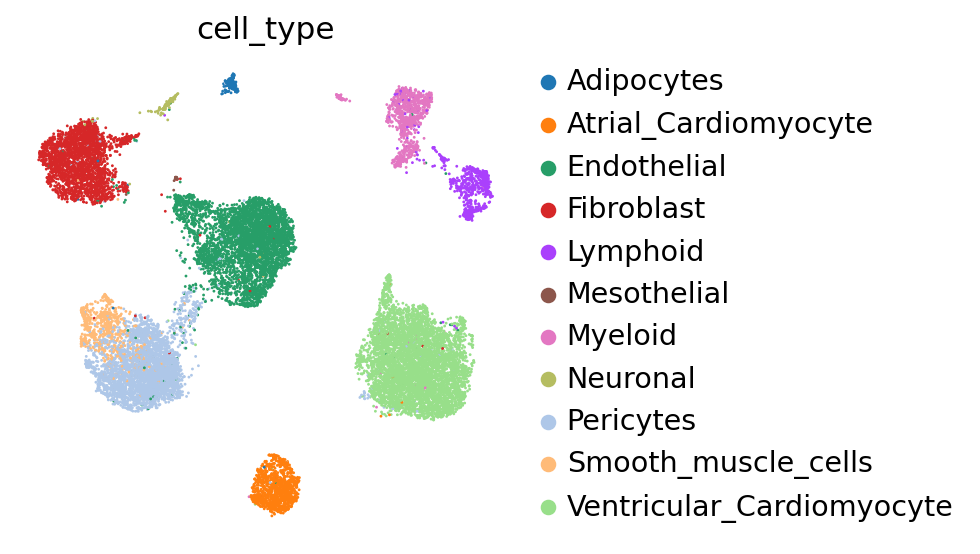

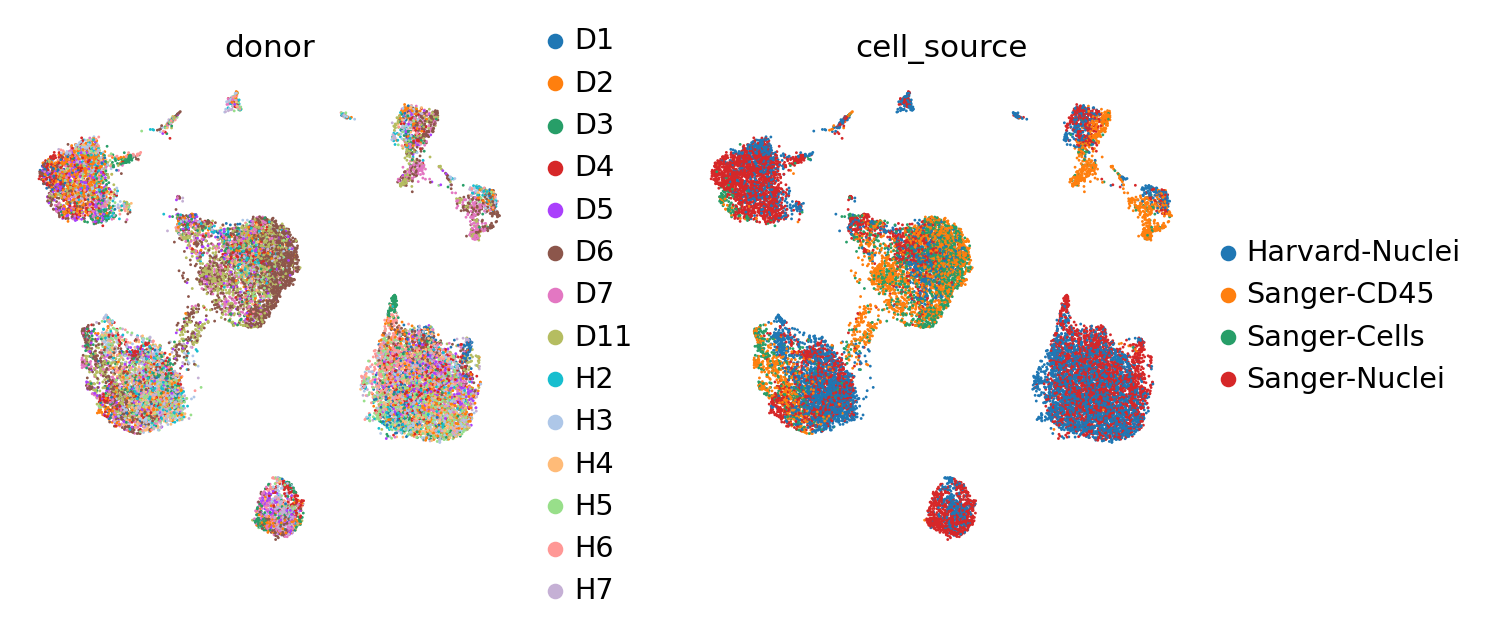

In [21]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor", "cell_source"],
    ncols=2,
    frameon=False,
)

We can see that scVI was able to correct for nuisance variation due to nuclei/whole cell, age group, and donor, while maintaining separation of cell types.